In [104]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from quantus.metrics import Complexity
import torch
import io
import glob

# import with torch to cpu
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)


path = 'outputs/epilepsy'
splits = np.arange(5)
attributions = []
files = glob.glob(path + '_[0-9].pkl')
for file in files:
    with open(file, 'rb') as f:
        attributions.append(CPU_Unpickler(f).load())

In [105]:
sens = {}
k = 0
for acc in attributions:
    k += 1
    if not 'relative_output_sensitivity' in acc.keys():
        print(k)
        continue
    for key in acc['relative_output_sensitivity'].keys():
        if not key in sens.keys():
            sens[key] = []
        sens[key].append(acc['relative_output_sensitivity'][key])
# temp = np.stack(sens['ig'])
# means = []
# for i in range(temp.shape[0]):
#     sens_temp = temp[i,:]
#     std = np.nanstd(sens_temp)
#     # remove samples larger than 5 std
#     print((sens_temp > 3*std + np.nanmean(sens_temp)).sum())
#     sens_temp = sens_temp[sens_temp < 3*std + np.nanmean(sens_temp)]
#     means.append(np.nanmean(sens_temp))


# remove samples larger than 5 std

for key in sens.keys():
    try:
        acc = np.log(np.nanmean(np.stack(sens[key]), 1))
        print(f'{key}: {np.mean(acc):.2f}({np.std(acc)/np.sqrt(5):.2f})')
    except:
        print(key)
    

ig: 14.65(0.24)
saliency: 17.37(0.24)
guided-backprop: 17.18(0.21)
gxi: 16.00(0.77)
filterbank_32_75_0.1_time_reg_0: 11.33(0.76)
freqmask_0.05_perturb_True_time_reg_1.0: 17.65(0.11)
freqrise_5000_64_0.5: 21.76(0.12)
freqrise_5000_32_0.5: 22.15(0.24)


In [106]:
deletion = attributions[0]['insertion']
sampling_percent = np.arange(0, 1.05, 0.05)
for key in ['filterbank_256_901_0.1', 'freqrise_10000_256_0.5']:
    plt.plot(sampling_percent, deletion[key][1], label=key)
    auc = np.trapz(deletion[key][1], sampling_percent)
    print(key, auc)
plt.legend()
plt.show()

KeyError: 'filterbank_256_901_0.1'

In [18]:
from sklearn.metrics import f1_score

f1s = []
for att in attributions:
    labels = att['labels'].numpy()
    predictions = att['predictions'].argmax(dim=1).numpy()
    f1s.append(f1_score(labels, predictions, average='weighted'))

print(np.mean(f1s), np.std(f1s))

0.8759062290589685 0.012189720534813054


In [37]:
insertion = {}
deletion = {}
complexities = {}
grad_complexties = {}
comp = Complexity()
for att in attributions:
    for key in att['insertion'].keys():
        if not key in insertion.keys():
            insertion[key] = []
            deletion[key] = []
        insertion[key].append(att['insertion'][key][1])
        deletion[key].append(att['deletion'][key][1])
        if not key in ['random', 'amplitude']:
            #compute complexity
            if not key in complexities.keys():
                complexities[key] = []
                grad_complexties[key] = []
            scores = []
            grad_scores = []
            for i in range(len(att[key])):
                if not 'filtermasks' in key:
                    expl = att[key][i].flatten(start_dim = 1).numpy()
                else:
                    expl = np.reshape(att[key][i], (att[key][i].shape[0], -1))
                if 'audio' in path or 'sleepedf' in path:
                    ex = np.maximum(att[key][i], 0).numpy()
                    if 'filterbank' in key:
                        ex = np.transpose(ex, (0, 2, 1))
                    # min max normalize
                    ex = (ex - np.min(ex, axis = -1, keepdims=True)) / (np.max(ex, axis = -1, keepdims=True) - np.min(ex, axis = -1, keepdims=True))
                    expl_grad = np.abs(np.diff(ex, axis = -1)).sum(axis=-1)
                    expl_grad = np.reshape(expl_grad, (att[key][i].shape[0], -1))
                else:
                    ex = np.maximum(att[key][i], 0).numpy()
                    # min max normalize
                    ex = (ex - np.min(ex, axis = 1, keepdims=True)) / (np.max(ex, axis = 1, keepdims=True) - np.min(ex, axis = 1, keepdims=True))
                    expl_grad = np.abs(np.diff(ex, axis = 1)).sum(axis = 1)
                    expl_grad = np.reshape(expl_grad, (att[key][i].shape[0], -1))


                expl = np.maximum(expl, 0)
                complexity = comp.evaluate_batch(expl, expl)
                complexity = np.nan_to_num(complexity)
                expl_grad = np.nan_to_num(expl_grad)
                scores += complexity.tolist()
                grad_scores += list(expl_grad)
            complexities[key].append(np.mean(scores))
            grad_complexties[key].append(np.mean(grad_scores))


/var/folders/xl/fct1_y7d2tn5g3_7qcd7m89h0000gn/T/ipykernel_41752/4247851454.py:36: RuntimeWarning: invalid value encountered in divide
  ex = (ex - np.min(ex, axis = 1, keepdims=True)) / (np.max(ex, axis = 1, keepdims=True) - np.min(ex, axis = 1, keepdims=True))


In [38]:
for key in complexities.keys():
    comp_temp = complexities[key]
    mean_ = np.mean(comp_temp)
    std_ = np.std(comp_temp)
    print(f'{key}: {mean_:.2f}({std_/np.sqrt(len(comp_temp)):.2f})')

freqrise_5001_64_0.5: 5.10(0.00)
filterbank_64_105_0.05: 1.28(0.34)
freqmask_0.05_perturb_True: 0.68(0.17)
ig: 2.80(0.10)
saliency: 2.75(0.07)
gxi: 2.71(0.16)
guided-backprop: 2.83(0.01)
filterbank_32_105_0.1_1.0: 0.33(0.06)
freqmask_0.05_perturb_True_1.0: 0.94(0.15)


In [39]:
for key in grad_complexties.keys():
    comp_temp = grad_complexties[key]
    mean_ = np.mean(comp_temp)
    std_ = np.std(comp_temp)
    print(f'{key}: {mean_:.4f}({std_:.2f})')

freqrise_5001_64_0.5: 7.4430(1.11)
filterbank_64_105_0.05: 0.9966(0.62)
freqmask_0.05_perturb_True: 2.5396(1.04)
ig: 6.1153(1.21)
saliency: 6.2246(0.48)
gxi: 4.6717(0.75)
guided-backprop: 7.3406(0.67)
filterbank_32_105_0.1_1.0: 0.1463(0.06)
freqmask_0.05_perturb_True_1.0: 1.4804(0.63)


freqrise_5001_64_0.5 10%: 0.471 +- 0.062
filterbank_64_105_0.05 10%: 0.727 +- 0.081
freqmask_0.05_perturb_True 10%: 0.787 +- 0.018
ig 10%: 0.540 +- 0.045
saliency 10%: 0.775 +- 0.021
gxi 10%: 0.782 +- 0.039
guided-backprop 10%: 0.770 +- 0.026
random 10%: 0.891 +- 0.022
amplitude 10%: 0.778 +- 0.020
filterbank_32_105_0.1_1.0 10%: 0.860 +- 0.020
freqmask_0.05_perturb_True_1.0 10%: 0.787 +- 0.020


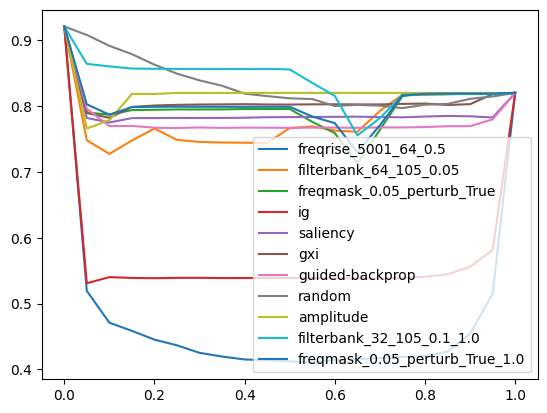

In [40]:
accuracies = deletion
sampling_percent = np.arange(0, 1.05, 0.05)

# reverse the order of the x-axis
for key in accuracies.keys():
    accs = np.stack(accuracies[key]) #/ np.stack(accuracies[key])[:,-1][:,np.newaxis]
    acc = np.mean(accs, 0)
    std = np.std(accs, 0)
    plt.plot(sampling_percent, acc, label=key)
    auc = np.trapz(acc, sampling_percent)
    print(f'{key} 10%: {acc[2]:.3f} +- {std[2]/np.sqrt(accs.shape[0]):.3f}')
    #print(f'25%: {acc[5]} +- {std[5]}')
plt.legend()
plt.show()

filterbank_128_501_0.1_time_reg_0: 9.34(0.27)
ig: 9.43(0.20)
saliency: 8.88(1.01)
gxi: 8.96(0.50)
guided-backprop: 9.56(0.28)
freqmask_0.05_perturb_True_time_reg_1.0: 12.28(0.16)
freqrise_10001_128_0.5: 10.65(0.15)


In [67]:
means

[2367.140706835295,
 4278.912347042814,
 6768.788458925305,
 4451.869449234009,
 6387.579886121848]

In [10]:
sens.keys()

dict_keys(['ig', 'saliency', 'guided-backprop', 'gxi', 'filterbank_64_105_0.05_time_reg_0', 'freqmask_0.05_perturb_True_time_reg_1.0', 'freqrise_5000_64_0.5'])

In [5]:
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

greens = cm.get_cmap('Greens', 256)
newcolors = greens(np.linspace(0, 1, 256))
pink = np.array([1, 1, 1, 1])
newcolors[:5, :] = pink
newcmp = ListedColormap(newcolors)


def vis_one_saliency_univariate(X, exp, ax, fig, alpha = 1, vmin = None, vmax = None, xmin = None, xmax = None):

    Xnp = X
    enp = exp
    T, d = Xnp.shape

    assert d == 1, 'vis_one_saliency_univariate is only for univariate inputs'

    if xmin is None:
        x_range = np.arange(T)
        xmin = min(x_range)
        xmax = max(x_range)
    else:
        x_range = np.linspace(xmin, xmax, T)

    print('enp', enp.shape)

    # Assumes heatmap:
    px, py = np.meshgrid(np.linspace(xmin, xmax, T + 1), [min(Xnp[:,0]), max(Xnp[:,0])])
    ax.plot(x_range, Xnp[:,0], color = 'black', alpha = 0.5)
    if vmin is None:
        vmin = enp.min()
    elif vmax is None:
        vmax = enp.max()
    cmap = ax.pcolormesh(px, py, enp, alpha = alpha, cmap = newcmp, norm = colors.Normalize(vmin = vmin, vmax = vmax))
    fig.colorbar(cmap, ax = ax)

/var/folders/xl/fct1_y7d2tn5g3_7qcd7m89h0000gn/T/ipykernel_69856/3017027310.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greens = cm.get_cmap('Greens', 256)


In [6]:
print((np.where(att["labels"]==4)[0]/10).astype(int))
print(np.where(att["labels"]==4)[0]%10)

[ 0  0  1  1  1  1  2  2  4  5  5  5  6  6  6  7  7  7  8  8  9  9  9  9
 10 10 12 12 13 13 13 14 14 14 15 15 15 16 16 17 18 19 21 21 22 22 23 23
 24 25 25 25 26 27 27 27 28 28 28 28 29 29 29 30 30 30 31 31 32 33 33 33
 33 34 34 35 35 35 37 37 37 38 38 38 39 39 39 40 40 41 41 42 43 44 44 44
 44 45 46 47 48 48 48 48 50 51 52 54 54 56 56 56 56 57 58 58 58 59 60 61
 61 62 63 63 63 64 64 64 65 65 65 67 67 67 68 68 69 70 70 71 72 72 73 74
 75 75 76 76 76 76 77 77 78 78 79 81 81 81 83 83 84 85 85 86 87 87 87 88
 88 89 90 90 90 90 90 92 93 93 94 95 95 96 96 97 98 99 99 99 99]
[3 4 0 4 7 8 6 7 4 1 3 5 2 3 8 2 5 8 0 2 2 3 6 7 0 1 4 8 0 6 7 0 1 9 5 6 9
 6 8 3 0 6 2 8 2 9 1 9 6 2 4 9 1 1 7 9 0 2 6 9 1 2 3 3 4 6 5 9 3 1 3 5 6 2
 9 4 5 9 1 5 8 0 3 4 0 2 3 4 8 0 7 5 7 1 2 5 6 3 3 7 0 2 3 7 8 5 7 1 4 0 4
 6 9 8 1 7 9 7 6 5 6 5 2 7 9 2 5 6 0 1 6 1 3 8 3 6 7 1 7 1 4 6 8 0 1 3 0 3
 4 5 0 1 0 5 3 2 7 8 2 3 4 5 9 2 0 4 8 3 4 4 0 2 3 5 6 3 0 5 7 6 9 0 3 9 8
 1 6 7 9]


enp (1, 1501)
enp (1, 1501)
enp torch.Size([1, 1501])
enp (1, 1501)
enp (1, 1501)
enp torch.Size([1, 1501])
enp (1, 1501)
enp (1, 1501)
enp torch.Size([1, 1501])


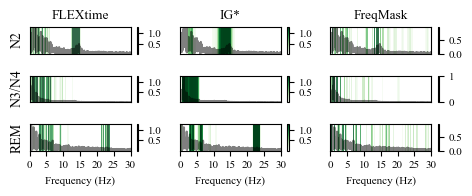

In [11]:
att = attributions[1]
label_names = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
# batch 2, idx 1 (N2), batch 2 idx 7 (REM), batch 2 idx 9 (N3/N4)
batch = 2
expl_smooth = att['filterbank_256_901_0.1'][batch].squeeze()
expl = att['filterbank_256_901_0.1'][batch].squeeze().numpy()
expl_ig = att['ig'][batch].squeeze().numpy()
expl_ig = np.maximum(expl_ig, 0)
expl_freq = att['freqmask_0.1_perturb_True_1.0'][batch]
fig, ax = plt.subplots(3, 3, figsize = (4.8, 2))
for i, idx in enumerate([1, 9, 7]):
    fs = 100
    data = att['data'][batch*10+idx].squeeze()
    data_freq = np.fft.rfft(data, axis = -1)
    freq_axis = np.fft.rfftfreq(expl[idx].shape[-1]*2-1, 1/fs)
    vis_one_saliency_univariate(np.abs(data_freq)[:, np.newaxis], expl[idx][np.newaxis,:], ax[i, 0], fig, xmin=0, xmax=50, alpha = 0.8)
    ax[0, 0].set_title('FLEXtime')
    ax[i, 0].set_ylabel(f'{label_names[att["labels"][batch*10+idx]]}', fontsize = 10)
    ax[i, 0].set_xlim([0, 30])
    if i == 2:
        ax[i, 0].set_xticks([0, 5, 10, 15, 20, 25, 30])
        ax[i, 0].set_xlabel('Frequency (Hz)', fontsize = 8)
    else:
        ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    if i == 1:
        vmax = 0.4
    else:
        vmax = 0.1
    vis_one_saliency_univariate(np.abs(data_freq)[:, np.newaxis], expl_ig[idx][np.newaxis,:], ax[i, 1], fig, xmin=0, xmax=50, vmax=vmax)
    ax[0, 1].set_title('IG*')
    ax[i, 1].set_xlim([0, 30])
    if i == 2:
        ax[i, 1].set_xticks([0, 5, 10, 15, 20, 25, 30])
        ax[i, 1].set_xlabel('Frequency (Hz)', fontsize = 8)
    else:
        ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    vis_one_saliency_univariate(np.abs(data_freq)[:, np.newaxis], expl_freq[idx][np.newaxis,:], ax[i, 2], fig, xmin=0, xmax=50, alpha = 0.8)
    ax[0, 2].set_title('FreqMask')
    ax[i, 2].set_xlim([0, 30])
    if i ==2:
        ax[i, 2].set_xticks([0, 5, 10, 15, 20, 25, 30])
        ax[i, 2].set_xlabel('Frequency (Hz)', fontsize = 8)
    else:
        ax[i, 2].set_xticks([])
    ax[i, 2].set_yticks([])
plt.tight_layout()
plt.savefig('/Users/theb/Documents/PhD/Udveksling/Explainability/flextime/sleepedfexamples.pdf')
plt.show()

enp (1, 1501)
enp (1, 1501)
enp (1, 1501)
enp (1, 1501)
enp (1, 1501)
enp (1, 1501)


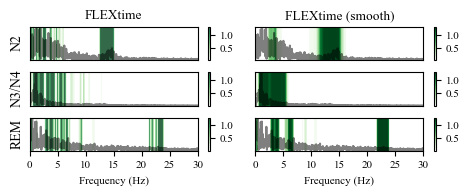

In [13]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 8
att = attributions[1]
label_names = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
# batch 2, idx 1 (N2), batch 2 idx 7 (REM), batch 2 idx 9 (N3/N4)
batch = 2
expl_smooth = att['filterbank_256_901_0.1'][batch].squeeze()
expl = att['filterbank_256_901_0.1'][batch].squeeze().numpy()
expl_ig = att['filterbank_256_901_0.1_1.0'][batch].squeeze().numpy()
expl_ig = np.maximum(expl_ig, 0)
expl_freq = att['freqmask_0.1_perturb_True_1.0'][batch]
fig, ax = plt.subplots(3, 2, figsize = (4.8, 2))
for i, idx in enumerate([1, 9, 7]):
    fs = 100
    data = att['data'][batch*10+idx].squeeze()
    data_freq = np.fft.rfft(data, axis = -1)
    freq_axis = np.fft.rfftfreq(expl[idx].shape[-1]*2-1, 1/fs)
    vis_one_saliency_univariate(np.abs(data_freq)[:, np.newaxis], expl[idx][np.newaxis,:], ax[i, 0], fig, xmin=0, xmax=50, alpha = 0.8)
    ax[0, 0].set_title('FLEXtime')
    ax[i, 0].set_ylabel(f'{label_names[att["labels"][batch*10+idx]]}', fontsize = 10)
    ax[i, 0].set_xlim([0, 30])
    if i == 2:
        ax[i, 0].set_xticks([0, 5, 10, 15, 20, 25, 30])
        ax[i, 0].set_xlabel('Frequency (Hz)', fontsize = 8)
    else:
        ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    if i == 1:
        vmax = 0.4
    else:
        vmax = 0.1
    vis_one_saliency_univariate(np.abs(data_freq)[:, np.newaxis], expl_ig[idx][np.newaxis,:], ax[i, 1], fig, xmin=0, xmax=50, vmax=None)
    ax[0, 1].set_title('FLEXtime (smooth)')
    ax[i, 1].set_xlim([0, 30])
    if i == 2:
        ax[i, 1].set_xticks([0, 5, 10, 15, 20, 25, 30])
        ax[i, 1].set_xlabel('Frequency (Hz)', fontsize = 8)
    else:
        ax[i, 1].set_xticks([])
    ax[i, 1].set_yticks([])
    #vis_one_saliency_univariate(np.abs(data_freq)[:, np.newaxis], expl_freq[idx][np.newaxis,:], ax[i, 2], fig, xmin=0, xmax=50, alpha = 0.8)
    #ax[0, 2].set_title('FreqMask')
    #ax[i, 2].set_xlim([0, 30])
    #if i ==2:
    #    ax[i, 2].set_xticks([0, 5, 10, 15, 20, 25, 30])
    #    ax[i, 2].set_xlabel('Frequency (Hz)', fontsize = 8)
    #else:
    #    ax[i, 2].set_xticks([])
    #ax[i, 2].set_yticks([])
plt.tight_layout()
plt.savefig('/Users/theb/Documents/PhD/Udveksling/Explainability/flextime/sleepedfexamples_smooth.pdf')
plt.show()

In [110]:
att = attributions[1]

filterbank_expl = np.concatenate(att['filterbank_256_901_0.1'])[:,:,0]
ig_expl = np.maximum(np.concatenate(att['ig']), 0)[:,0,:]
labels = att['labels']
preds = np.argmax(att['predictions'], axis = -1)
true_idx = labels == preds
filterbank_correct = filterbank_expl[true_idx]
# min max normalize
filterbank_correct = (filterbank_correct - np.min(filterbank_correct, axis = -1, keepdims=True)) / (np.max(filterbank_correct, axis = -1, keepdims=True) - np.min(filterbank_correct, axis = -1, keepdims=True))
ig_correct = ig_expl[true_idx]
# min max normalize
ig_correct = (ig_correct - np.min(ig_correct, axis = -1, keepdims=True)) / (np.max(ig_correct, axis = -1, keepdims=True) - np.min(ig_correct, axis = -1, keepdims=True))
wrong_idx = labels != preds
filterbank_wrong = filterbank_expl[wrong_idx]
ig_wrong = ig_expl[wrong_idx]

data = att['data'].squeeze()
freq_data = np.fft.rfft(data, axis = -1)
data_labels = labels


correct_labels = labels[true_idx]
wrong_labels = labels[wrong_idx]
wrong_preds = preds[wrong_idx]

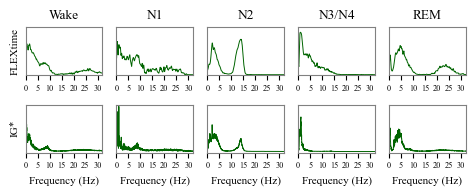

In [252]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 8
fig,ax = plt.subplots(2, 5, figsize = (4.8,2))
label_names = ['Wake', 'N1', 'N2', 'N3/N4', 'REM']
ax[0,0].set_ylabel('FLEXtime')
ax[1,0].set_ylabel('IG*')
for lab in range(5):
    idx = correct_labels == lab
    mean_expl = np.mean(filterbank_correct[idx], axis = 0)
    ig_mean = np.mean(ig_correct[idx], axis = 0)
    ax[0,lab].plot(freq_axis, mean_expl, color = 'darkgreen', linewidth = 0.7)
    ax[0,lab].set_xlim(0,32)
    ax[0,lab].set_ylim(-0.01,1.1)
    # remove x ticks 
    ax[0,lab].set_xticks([0, 5, 10, 15, 20, 25, 30])
    ax[0,lab].tick_params(axis='both', which='major', labelsize=6)

    # set tick size

    
    ax[1,lab].plot(freq_axis, ig_mean, color = 'darkgreen', linewidth = 0.7)
    ax[1,lab].set_xlim(0,32)
    ax[1,lab].set_xlabel('Frequency (Hz)')
    ax[1,lab].set_xticks([0, 5, 10, 15, 20, 25, 30])
    ax[1,lab].tick_params(axis='both', which='major', labelsize=6)
    ax[1,lab].set_ylim(-0.01,0.4)
    ax[1,lab].spines['bottom'].set_color('grey')
    ax[1,lab].spines['top'].set_color('grey') 
    ax[1,lab].spines['right'].set_color('grey')
    ax[1,lab].spines['left'].set_color('grey')
    ax[0,lab].spines['bottom'].set_color('grey')
    ax[0,lab].spines['top'].set_color('grey')
    ax[0,lab].spines['right'].set_color('grey')
    ax[0,lab].spines['left'].set_color('grey')

    #if not lab == 0:
    # remove y ticks
    ax[0,lab].set_yticks([])
    ax[1,lab].set_yticks([])
    
    ax[0,lab].set_title(f'{label_names[lab]}')
    # ax[2,lab].plot(freq_axis, np.abs(freq_data)[data_labels==lab].mean(axis = 0))
    # ax[2,lab].set_xlim(0,30)
    # ax[2,lab].set_ylabel('Data')

# idx = correct_labels == lab
# mean_expl = np.mean(filterbank_correct[idx], axis = 0)
# ig_mean = np.mean(ig_correct[idx], axis = 0)
# fig.suptitle(f'Label: {lab}')
# ax[0].plot(freq_axis, mean_expl)
# #vis_one_saliency_univariate(np.abs(freq_data)[data_labels==lab].mean(axis = 0)[:,np.newaxis], mean_expl[np.newaxis,:], ax[0], fig)
# ax[0].set_xlim(0,30)
# ax[0].set_ylabel('FLEXtime')
# #vis_one_saliency_univariate(np.abs(freq_data)[data_labels==lab].mean(axis = 0)[:,np.newaxis], ig_mean[np.newaxis,:], ax[1], fig)
# ax[1].plot(freq_axis, ig_mean)
# ax[1].set_xlim(0,30)
# ax[1].set_ylabel('IG')
# # ax[0].set_title(f'Correctly predicted as {lab}')
# # ax[2,0].plot(freq_axis, np.abs(freq_data)[data_labels==lab].mean(axis = 0))
# # ax[2,0].set_xlim(0,30)
# # ax[2,0].set_ylabel('Data')

plt.tight_layout()
plt.savefig('/Users/theb/Documents/PhD/Udveksling/Explainability/flextime/casestudy.pdf', bbox_inches = 'tight')
plt.show()

In [50]:
gender_path = 'outputs/audio_gender_0.pkl'
with open(gender_path, 'rb') as f:
    gender_att = CPU_Unpickler(f).load()

gender_att.keys()

dict_keys(['predictions', 'labels', 'deletion', 'insertion', 'freqrise_10001_128_0.5', 'filterbank_128_501_0.1', 'filtermasks_filterbank_128_501_0.1', 'freqmask_0.1_perturb_True', 'ig', 'saliency', 'gxi', 'guided-backprop', 'filterbank_512_501_0.05_1.0', 'filtermasks_filterbank_512_501_0.05_1.0', 'sensitivity', 'freqmask_0.1_perturb_True_1.0'])

In [55]:
digit_path = 'outputs/audio_digit_0.pkl'
with open(digit_path, 'rb') as f:
    digit_att = CPU_Unpickler(f).load()
digit_att.keys()

dict_keys(['predictions', 'labels', 'deletion', 'insertion', 'freqrise_10001_128_0.5', 'filterbank_128_501_0.1', 'filtermasks_filterbank_128_501_0.1', 'freqmask_0.05_perturb_True', 'ig', 'saliency', 'gxi', 'guided-backprop', 'filterbank_512_901_0.05_1.0', 'filtermasks_filterbank_512_901_0.05_1.0', 'sensitivity', 'freqmask_0.05_perturb_True_1.0'])

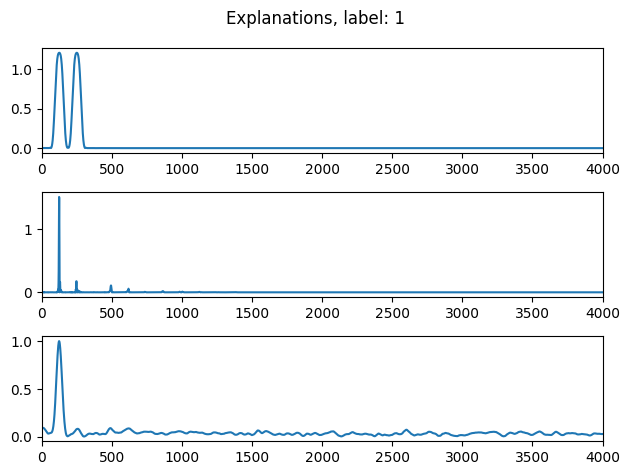

In [46]:

g_batch = 0
expl_gender = gender_att['filterbank_128_501_0.1'][g_batch].squeeze().numpy()
expl_ig_gender = gender_att['ig'][g_batch].squeeze().numpy()
expl_ig_gender = np.maximum(expl_ig_gender, 0)
expl_freq_gender = gender_att['freqrise_10001_128_0.5'][g_batch]
fig, ax = plt.subplots(3, 1)
g_idx = 1
fig.suptitle(f'Explanations, label: {gender_att["labels"][g_batch*10+g_idx]}')
ax[0].plot(expl_gender[g_idx])
ax[0].set_xlim(0, 4000)
ax[1].plot(expl_ig_gender[g_idx])
ax[1].set_xlim(0, 4000)
ax[2].plot(expl_freq_gender[g_idx])
ax[2].set_xlim(0, 4000)
plt.tight_layout()
plt.show()

In [99]:
d_batch = 6
digit_att["labels"][d_batch*10:d_batch*10+10]

tensor([6, 5, 7, 8, 2, 1, 8, 5, 3, 5])

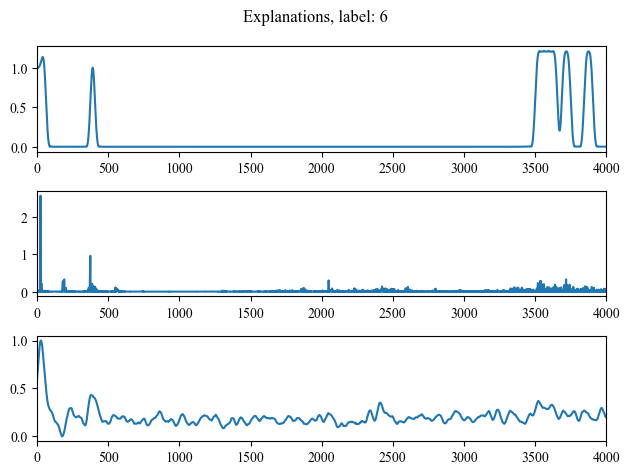

In [100]:
expl_digit = digit_att['filterbank_128_501_0.1'][d_batch].squeeze().numpy()
expl_ig_digit = digit_att['ig'][d_batch].squeeze().numpy()
expl_ig_digit = np.maximum(expl_ig_digit, 0)
expl_freq_digit = digit_att['freqrise_10001_128_0.5'][d_batch]
fig, ax = plt.subplots(3, 1)
d_idx = 0
fig.suptitle(f'Explanations, label: {digit_att["labels"][d_batch*10+d_idx]}')
ax[0].plot(expl_digit[d_idx])
ax[0].set_xlim(0, 4000)
ax[1].plot(expl_ig_digit[d_idx])
ax[1].set_xlim(0, 4000)
ax[2].plot(expl_freq_digit[d_idx])
ax[2].set_xlim(0, 4000)
plt.tight_layout()
plt.show()

In [101]:
from src.data.audio import AudioNetDataset
data_path = '/Users/theb/Desktop/data/AudioMNIST/'
test_dset = AudioNetDataset(data_path, True, 'test', splits = [0], labeltype = 'digit', subsample = 1000, seed = 0)                     
sample = test_dset.__getitem__(d_batch*10+d_idx)
data = sample[0]
fft_data = np.abs(np.fft.rfft(data))[0]

gender_dset = AudioNetDataset(data_path, True, 'test', splits = [0], labeltype='gender', subsample = 1000, seed = 0)
g_sample = gender_dset.__getitem__(g_batch*10+g_idx)
g_data = g_sample[0]
g_fft_data = np.abs(np.fft.rfft(g_data))[0]

enp (1, 4001)
enp (1, 4001)
enp torch.Size([1, 4001])
enp (1, 4001)
enp (1, 4001)
enp torch.Size([1, 4001])


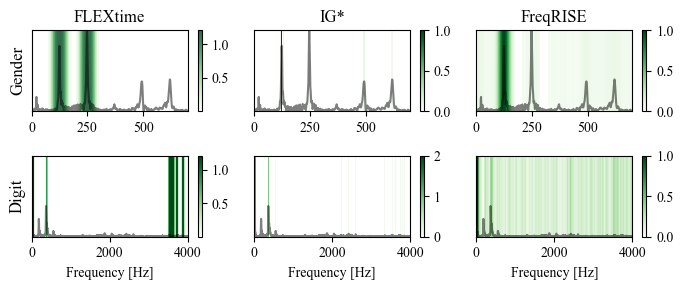

In [103]:
# plot explanations
# set font to times new roman
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(2, 3, figsize = (7, 3))
vis_one_saliency_univariate(g_fft_data.T, expl_gender[g_idx][np.newaxis, :], ax[0,0], fig, alpha = 0.8)
# set_xlim
ax[0,0].set_xlim(0, 700)
ax[0,0].set_title('FLEXtime')
ax[0,0].set_ylabel('Gender', fontsize = 12)
ax[0,0].set_yticks([])
vis_one_saliency_univariate(g_fft_data.T, expl_ig_gender[g_idx][np.newaxis, :], ax[0,1], fig, vmax = 1)
ax[0,1].set_title('IG*')
ax[0,1].set_xlim(0, 700)
ax[0,1].set_yticks([])
vis_one_saliency_univariate(g_fft_data.T, expl_freq_gender[g_idx][np.newaxis, :], ax[0,2], fig, alpha = 1)
ax[0,2].set_title('FreqRISE')
ax[0,2].set_xlim(0, 700)

ax[0,2].set_yticks([])

vis_one_saliency_univariate(fft_data.T, expl_digit[d_idx][np.newaxis, :], ax[1,0], fig)
ax[1,0].set_yticks([])
ax[1,0].set_ylabel('Digit', fontsize = 12)
ax[1,0].set_xlabel('Frequency [Hz]')

vis_one_saliency_univariate(fft_data.T, expl_ig_digit[d_idx][np.newaxis, :], ax[1,1], fig, vmax = 2)
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('Frequency [Hz]')

vis_one_saliency_univariate(fft_data.T, expl_freq_digit[d_idx][np.newaxis, :], ax[1,2], fig, alpha = 1)
ax[1,2].set_yticks([])
ax[1,2].set_xlabel('Frequency [Hz]')

plt.tight_layout()
# save plot
path = '/Users/theb/Documents/PhD/Udveksling/Explainability/flextime/audio_'
plt.savefig(f'{path}flextime_ig_freqrise.pdf')
plt.show()